扫描数据集中: /home/chenx/code/medical_project/data/LIDC-IDRI-slices ...


100%|██████████| 100/100 [00:00<00:00, 321.70it/s]


筛选出 222 个正样本。
开始处理流程...


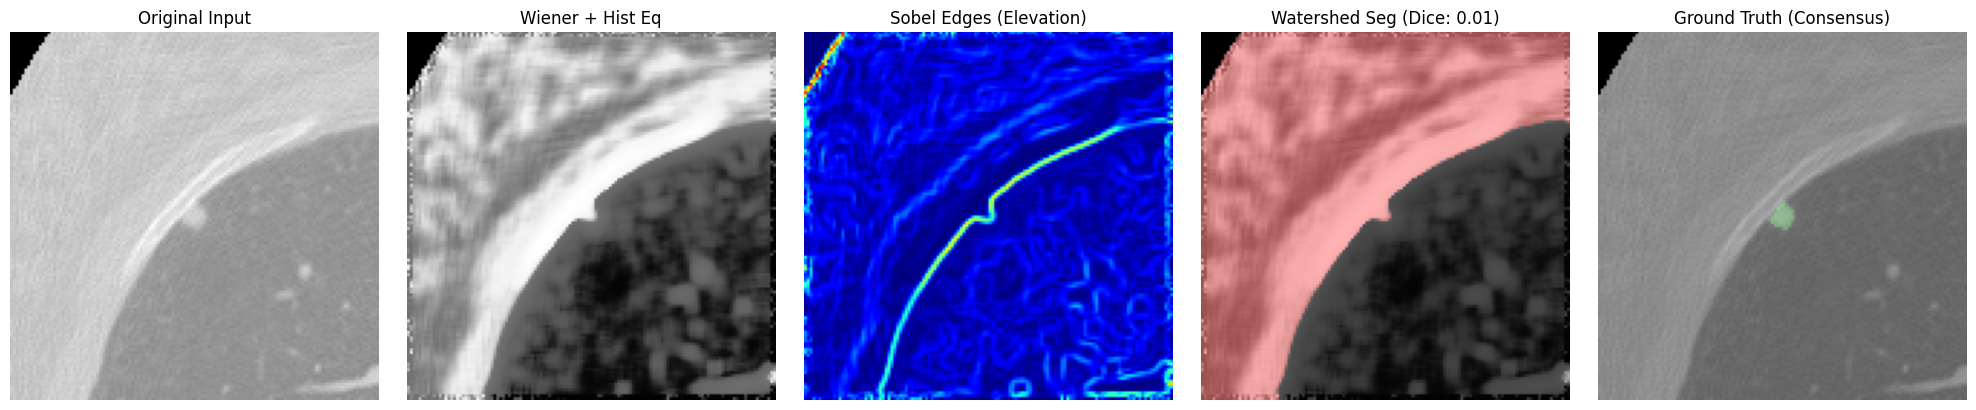

/home/chenx/miniconda3/envs/lidc/lib/python3.11/site-packages/scipy/signal/_signaltools.py:1673: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/chenx/miniconda3/envs/lidc/lib/python3.11/site-packages/scipy/signal/_signaltools.py:1673: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


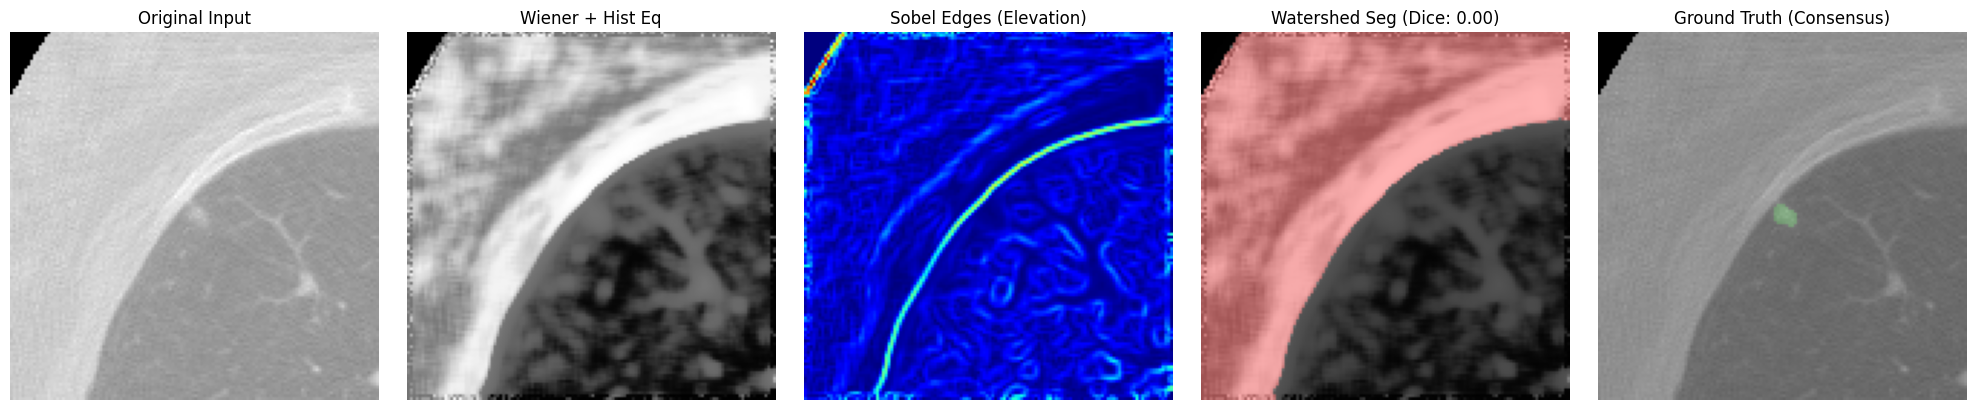

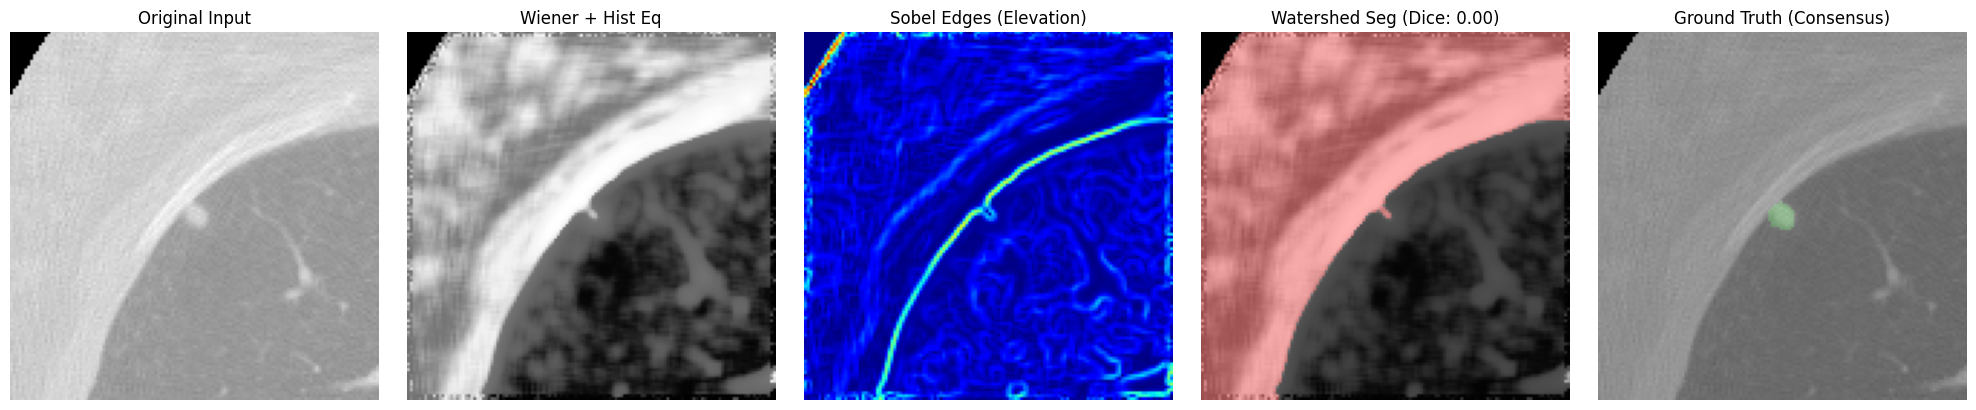

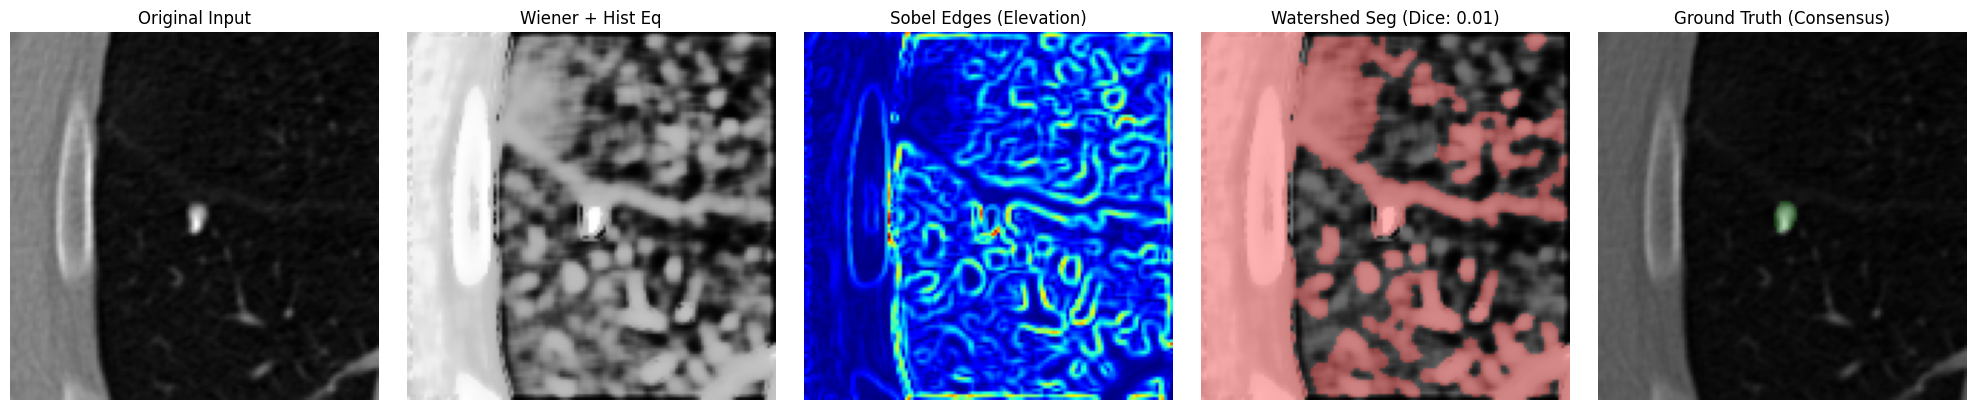

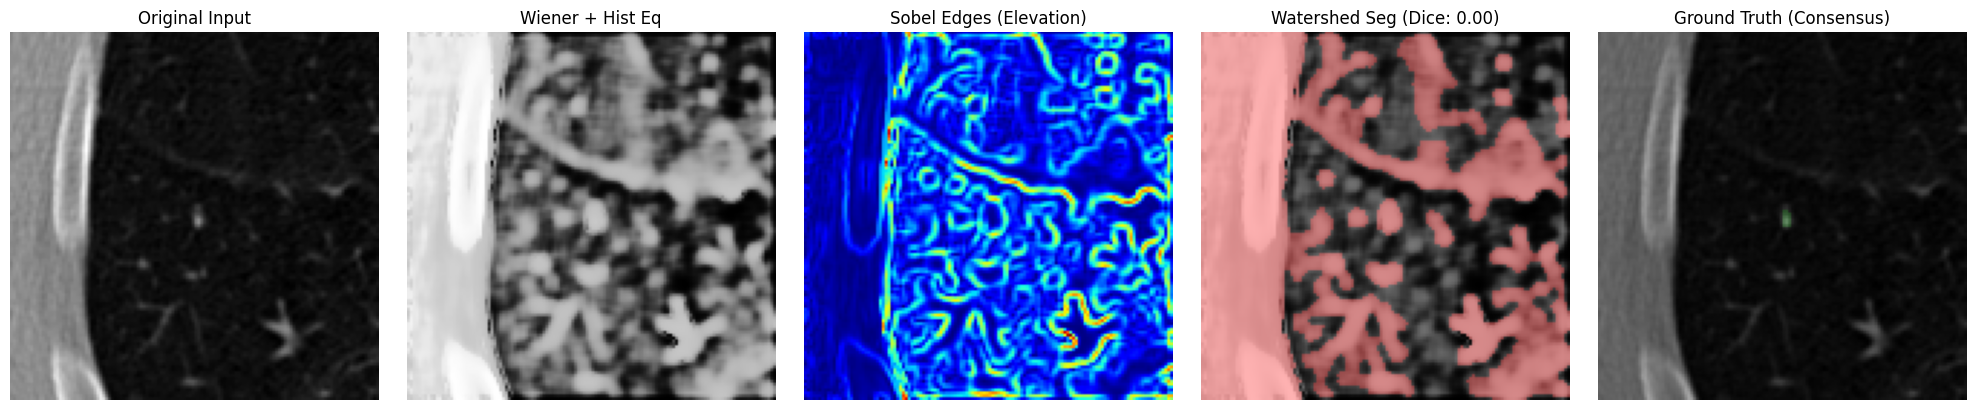

=== 最终结果 ===
处理样本数: 222
平均 Dice Score: 0.0263


In [1]:
#没有用离心率，混在一起
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import wiener
from skimage import exposure, filters, segmentation, morphology, color, measure, util
from tqdm import tqdm

# ================= 配置区域 =================
DATA_DIR = "/home/chenx/code/medical_project/data/LIDC-IDRI-slices"
# 如果你的图片不是 128x128，这里可以调整，或者代码里会自动 resize
IMAGE_SIZE = (128, 128) 
SAVE_RESULT_DIR = "./output_course_project"
# ===========================================

class LIDC_CourseProcessor:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        if not os.path.exists(SAVE_RESULT_DIR):
            os.makedirs(SAVE_RESULT_DIR)

    def load_data_and_gt(self):
        """
        加载数据并根据 '3/4 共识' 逻辑生成 Ground Truth (保持不变)
        """
        # 获取所有包含 images 的路径（假设结构为 Patient/Nodule/images/*.png）
        patient_dirs = glob.glob(os.path.join(self.data_dir, '**', 'images'), recursive=True)
        valid_samples = []
        
        print(f"扫描数据集中: {self.data_dir} ...")
        
        # 限制处理数量方便调试，正式跑时可以去掉 [:100]
        for img_dir in tqdm(patient_dirs[:100]): 
            base_dir = os.path.dirname(img_dir)
            image_files = glob.glob(os.path.join(img_dir, "*.png"))
            
            for img_path in image_files:
                filename = os.path.basename(img_path)
                
                # 读取原始图像 (转为灰度)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, IMAGE_SIZE)

                # 读取 4 个 Mask
                masks = []
                for i in range(4):
                    mask_path = os.path.join(base_dir, f"mask-{i}", filename)
                    if os.path.exists(mask_path):
                        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                        m = cv2.resize(m, IMAGE_SIZE)
                        masks.append(m)
                    else:
                        masks.append(np.zeros(IMAGE_SIZE, dtype=np.uint8))

                # === 共识逻辑 ===
                mask_sums = [np.sum(m) for m in masks]
                # 统计有多少个医生认为有结节 (阈值>10排除噪点)
                votes = sum(1 for s in mask_sums if s > 10)

                # 判定: >2 人 (即3或4人) 同意才有病
                if votes > 2:
                    # 取面积最大的 mask 作为 GT
                    gt_mask = masks[np.argmax(mask_sums)]
                    # 二值化 GT
                    gt_mask = (gt_mask > 127).astype(np.uint8)
                    
                    valid_samples.append({
                        'image': img,
                        'mask': gt_mask,
                        'id': f"{os.path.basename(base_dir)}_{filename}"
                    })
        
        print(f"筛选出 {len(valid_samples)} 个正样本。")
        return valid_samples

    def process_pipeline(self, image_uint8):
        """
        基于你指定的新路径：
        Wiener -> Equalize Hist -> Otsu+Sobel+Watershed -> Remove Small Objects
        """
        # 0. 预处理：转为 float [0, 1]
        img_float = util.img_as_float(image_uint8)

        # === 1. 去噪: Scipy Wiener ===
        # 这是一个自适应低通滤波，虽然是空域实现，但在统计意义上符合维纳滤波原理
        # mysize=(5,5) 是局部窗口大小
        denoised = wiener(img_float, mysize=(5, 5))
        # 裁剪可能出现的越界值
        denoised = np.clip(denoised, 0, 1)

        # === 2. 增强: Skimage Histogram Equalization ===
        # 全局直方图均衡化
        enhanced = exposure.equalize_hist(denoised)

        # === 3. 分割: Otsu + Sobel + Watershed ===
        
        # A. 生成 Elevation Map (地形图/梯度图)
        # 使用 Sobel 算子检测边缘，边缘处梯度大，作为分水岭的"山脊"
        elevation_map = filters.sobel(enhanced)

        # B. 生成 Markers (种子点)
        # 我们需要告诉分水岭算法哪里肯定是背景，哪里肯定是前景
        
        # 使用 Otsu 找到一个全局阈值
        try:
            thresh_val = filters.threshold_otsu(enhanced)
        except ValueError:
            thresh_val = 0.5 # fallback

        # 策略：
        # 背景种子：像素值很低的地方 (< 阈值)
        # 前景种子：像素值很高的地方 (> 阈值)。
        # 注意：肺结节通常是高亮区域。但在全局均衡化后，骨骼和外部空气边界也可能很亮。
        # 为了更精准，我们取比 Otsu 阈值更高一点的值作为前景种子
        
        markers = np.zeros_like(enhanced, dtype=np.int32)
        # 标记 1: 肯定是背景 (很暗的区域)
        markers[enhanced < thresh_val * 0.7] = 1 
        # 标记 2: 肯定是前景/结节 (很亮的区域)
        markers[enhanced > thresh_val * 1.3] = 2
        
        # C. 运行 Watershed
        # 这里的关键思想是：让水从 markers 开始漫延，直到遇到 sobel 边缘（山脊）停止
        segmentation_raw = segmentation.watershed(elevation_map, markers)
        
        # 提取我们要的前景部分 (Label 2)
        binary_pred = (segmentation_raw == 2)

        # === 4. 后处理: 移除小物体 ===
        # 使用 skimage 的形态学操作移除细小的噪点
        # min_size: 小于 30 个像素的连通域被删掉
        cleaned_pred = morphology.remove_small_objects(binary_pred, min_size=30)
        
        # 转换回 uint8 方便后续计算
        final_mask = cleaned_pred.astype(np.uint8)

        return {
            'denoised': denoised,
            'enhanced': enhanced,
            'edges': elevation_map,
            'prediction': final_mask
        }

    def calculate_dice(self, y_true, y_pred):
        intersection = np.sum(y_true * y_pred)
        return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

    def visualize(self, original, results, gt_mask, dice_score, save_path):
        """
        使用 label2rgb 进行高级可视化
        """
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        ax = axes.ravel()

        # 1. 原图
        ax[0].imshow(original, cmap='gray')
        ax[0].set_title('Original Input')

        # 2. 去噪 + 增强
        ax[1].imshow(results['enhanced'], cmap='gray')
        ax[1].set_title('Wiener + Hist Eq')

        # 3. 中间状态：Sobel 边缘 (决定了分水岭的边界)
        ax[2].imshow(results['edges'], cmap='jet')
        ax[2].set_title('Sobel Edges (Elevation)')

        # 4. 分割结果 (伪彩色叠加)
        # label2rgb 可以把 mask 半透明地叠在原图上
        # bg_label=0 表示背景不着色
        overlay = color.label2rgb(results['prediction'], image=results['enhanced'], 
                                  bg_label=0, colors=['red'], alpha=0.3)
        ax[3].imshow(overlay)
        ax[3].set_title(f'Watershed Seg (Dice: {dice_score:.2f})')

        # 5. Ground Truth (对比)
        gt_overlay = color.label2rgb(gt_mask, image=original, 
                                     bg_label=0, colors=['green'], alpha=0.3)
        ax[4].imshow(gt_overlay)
        ax[4].set_title('Ground Truth (Consensus)')

        for a in ax:
            a.axis('off')

        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()

    def run(self):
        samples = self.load_data_and_gt()
        if not samples:
            print("未找到有效数据，请检查路径。")
            return

        dice_scores = []
        
        print("开始处理流程...")
        # 处理前 5 个样本用于展示
        for idx, sample in enumerate(samples):
            img = sample['image']
            gt = sample['mask']
            
            # 运行处理管线
            res = self.process_pipeline(img)
            
            # 评估
            dice = self.calculate_dice(gt, res['prediction'])
            dice_scores.append(dice)
            
            # 可视化前 5 张
            if idx < 5:
                save_name = os.path.join(SAVE_RESULT_DIR, f"result_{idx}.png")
                self.visualize(img, res, gt, dice, save_name)

        print(f"=== 最终结果 ===")
        print(f"处理样本数: {len(dice_scores)}")
        print(f"平均 Dice Score: {np.mean(dice_scores):.4f}")

if __name__ == "__main__":
    processor = LIDC_CourseProcessor(DATA_DIR)
    processor.run()